
# CNN-based Multi-Class Flower Classification

### Definition of the Problem
The goal of this project is to develop a Convolutional Neural Network (CNN) model that can accurately classify images of flowers into one of five categories: Sunflower, Orchid, Lotus, Lily, and Tulip. Accurate classification of flower species has applications in agriculture, botanical research, education and etc.

### Data Acquisition

The dataset used in this project consists of images of five different flower species. It was obtained from kaggle.com where it was uploaded by Kausthub Kannan(owner) and edited/updated by DesolationOfSmaug(collaborator) (https://www.kaggle.com/datasets/kausthubkannan/5-flower-types-classification-dataset/data). The images are organized into folders named after each flower class.

To prepare the data for modeling, the dataset will be split into training and testing sets with an 80-20 ratio. This ensures that the model can be trained on a substantial portion of the data while still being evaluated on unseen images. This is the link for the dataset that has already been split to training and testing - https://drive.google.com/drive/folders/1jiiJCfZIb_o87rKZtW6WBA99bzzuI1Cq?usp=sharing.

***Note!***

Building and training this model was done in google colab. There could be minor errors you encounter if you try to run it on other platforms. It will be mostly problems relating to the directory of the dataset. All the necessaray information has been provided just change the code for the model to run.

### Import the required librareis for the project

In [8]:
# Import the required Libraries
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

### Loading the Dataset / Splitting Dataset

##### Splitting the Dataset into Training and Testing Sets

Here, we assume that the dataset is already split into train and test. If not, the splitfolders code below
will help split the dataset into an 80:20 ratio.

There is also a data cleansing step to check for corrupted images before proceeding. This step is important
to avoid any runtime errors and ensure training images are valid.


In [10]:
# Define dataset path and output directory
dataset_dir = '/content/drive/MyDrive/flower_images'  # Original dataset path in Google Drive
output_dir = '/content/drive/MyDrive/flower_data_split'  # Output directory in MyDrive

# Check if the output directory already exists to avoid re-splitting
if not os.path.exists(output_dir):
    import splitfolders  # Ensure you have splitfolders installed
    # Split the dataset into training (80%) and testing (20%)
    splitfolders.ratio(
        dataset_dir,  # Path to the original dataset
        output=output_dir,  # Output directory
        seed=42,  # For reproducibility
        ratio=(0.8, 0.2),  # 80% training, 20% testing
    )

# Define paths for training and testing directories
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')

print(f"Training data directory: {train_dir}")
print(f"Testing data directory: {test_dir}")

Copying files: 5000 files [02:42, 30.84 files/s]

Training data directory: /content/drive/MyDrive/flower_data_split/train
Testing data directory: /content/drive/MyDrive/flower_data_split/test


### Data Exploration and Analysis

##### Counting the Number of Images per Class
We will analyze the distribution of images across the different classes in both the training and testing datasets. Count the number of images in each class for both the training and testing sets.
This helps confirm if the split is balanced.

In [13]:
def count_pictures(folder_path):
    """Counts the number of image files in a folder."""
    image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp')
    image_count = 0
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(image_extensions):
            image_count += 1
    return image_count

# Define the main subdirectories
main_subdirs = ['train', 'test']

# Loop through the main subdirectories
for main_subdir in main_subdirs:
    main_subdir_path = os.path.join(output_dir, main_subdir)
    # Get the subfolders within the main subdirectory
    subfolders = [f for f in os.listdir(main_subdir_path) if os.path.isdir(os.path.join(main_subdir_path, f))]
    # Loop through the subfolders and count pictures
    for subfolder in subfolders:
        folder_path = os.path.join(main_subdir_path, subfolder)
        num_pictures = count_pictures(folder_path)
        print(f"Number of pictures in '{folder_path}': {num_pictures}")


print(f"\n")
output_dir = '/content/drive/MyDrive/flower_data_split'

train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')

print("Train - Classes in the dataset:")
for folder in os.listdir(train_dir):
    print(f"- {folder}: {len(os.listdir(os.path.join(train_dir, folder)))} images")

print(f"\n")
print("Test - Classes in the dataset:")
for folder in os.listdir(test_dir):
    print(f"- {folder}: {len(os.listdir(os.path.join(test_dir, folder)))} images")


Number of pictures in '/content/drive/MyDrive/flower_data_split/train/Sunflower': 800
Number of pictures in '/content/drive/MyDrive/flower_data_split/train/Orchid': 800
Number of pictures in '/content/drive/MyDrive/flower_data_split/train/Lotus': 800
Number of pictures in '/content/drive/MyDrive/flower_data_split/train/Lilly': 799
Number of pictures in '/content/drive/MyDrive/flower_data_split/train/Tulip': 800
Number of pictures in '/content/drive/MyDrive/flower_data_split/test/Sunflower': 200
Number of pictures in '/content/drive/MyDrive/flower_data_split/test/Orchid': 200
Number of pictures in '/content/drive/MyDrive/flower_data_split/test/Lotus': 200
Number of pictures in '/content/drive/MyDrive/flower_data_split/test/Lilly': 200
Number of pictures in '/content/drive/MyDrive/flower_data_split/test/Tulip': 200


Train - Classes in the dataset:
- Sunflower: 800 images
- Orchid: 800 images
- Lotus: 800 images
- Lilly: 800 images
- Tulip: 800 images


Test - Classes in the dataset:
- S

##### Visualizing the Class Distribution

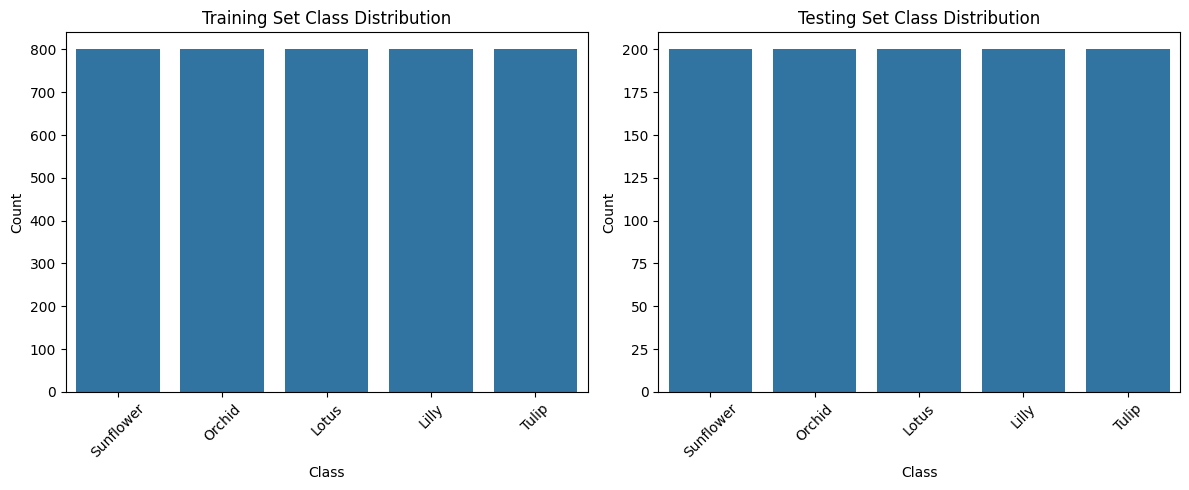

In [14]:
# Collect class counts
train_counts = {}
test_counts = {}

for folder in os.listdir(train_dir):
    train_counts[folder] = len(os.listdir(os.path.join(train_dir, folder)))

for folder in os.listdir(test_dir):
    test_counts[folder] = len(os.listdir(os.path.join(test_dir, folder)))

# Create DataFrames
train_df = pd.DataFrame(list(train_counts.items()), columns=['Class', 'Count'])
test_df = pd.DataFrame(list(test_counts.items()), columns=['Class', 'Count'])

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='Class', y='Count', data=train_df)
plt.title('Training Set Class Distribution')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x='Class', y='Count', data=test_df)
plt.title('Testing Set Class Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Data Preparation
##### Data Augmentation and Preprocessing
To enhance the model's ability to generalize, we will apply data augmentation techniques such as rotation, width and height shifts, shear, zoom, and horizontal flipping. Using ImageDataGenerator for data augmentation can help reduce overfitting by generating new training samples from
existing images (random transformations such as rotation, shift, zoom, flipping, etc.).

In [15]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/content/drive/MyDrive/flower_data_split/train'
test_dir = '/content/drive/MyDrive/flower_data_split/test'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


##### Visualizing Sample Augmented Images

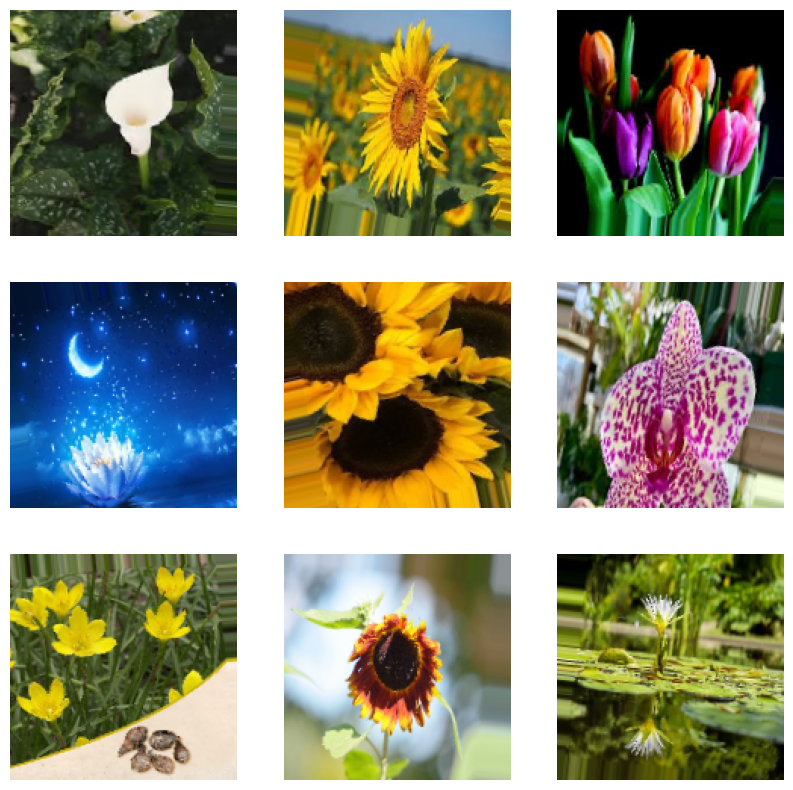

In [16]:
# Visualize some images from the training set
data_batch, labels_batch = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = data_batch[i]
    plt.imshow(img)
    plt.axis('off')
plt.show()

### Build CNN Model

We will construct a CNN model with convolutional layers followed by pooling layers, and a fully connected layer at the end. Below is a baseline CNN model. We'll do multiple iterations: first a baseline, then we will adjust the training
and validation parameters for improved performance.

In [ ]:
# Build the CNN Model
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Fourth Convolutional Block
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Global Average Pooling and Fully Connected Layers
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Regularization
    Dense(train_generator.num_classes, activation='softmax')
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 15, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 457,413 (1.74 MB)

 Trainable params: 456,453 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

### Compiling the Model

We will compile the model using the Adam optimizer and categorical cross-entropy loss function, suitable for multi-class classification.

In [ ]:
# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


### Training the Model

We will train the model for up to 100 epochs with early stopping and learning rate reduction callbacks to prevent overfitting and optimize training time.

In [ ]:
# Callbacks to improve training efficiency
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

### TRAINING (FIRST ITERATION)

In [ ]:
# Train the Model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    callbacks=callbacks
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 865s 7s/step - accuracy: 0.3062 - loss: 1.7703 - val_accuracy: 0.2040 - val_loss: 1.6157 - learning_rate: 1.0000e-05
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 110s 375ms/step - accuracy: 0.4226 - loss: 1.4231 - val_accuracy: 0.2080 - val_loss: 1.6184 - learning_rate: 1.0000e-05
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 375ms/step - accuracy: 0.4525 - loss: 1.3530 - val_accuracy: 0.3680 - val_loss: 1.4404 - learning_rate: 1.0000e-05
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 379ms/step - accuracy: 0.5296 - loss: 1.2305 - val_accuracy: 0.5520 - val_loss: 1.1707 - learning_rate: 1.0000e-05
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 54s 412ms/step - accuracy: 0.5286 - loss: 1.2347 - val_accuracy: 0.5890 - val_loss: 1.0594 - learning_rate: 1.0000e-05
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 412ms/step - accuracy: 0.5321 - loss: 1.1959 - val_accuracy: 0.6180 - val_loss: 1.0251 - learning_rate: 1.0000e-05
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 408ms/st

### Evaluating the Model
#### Plotting Training and Validation Metrics

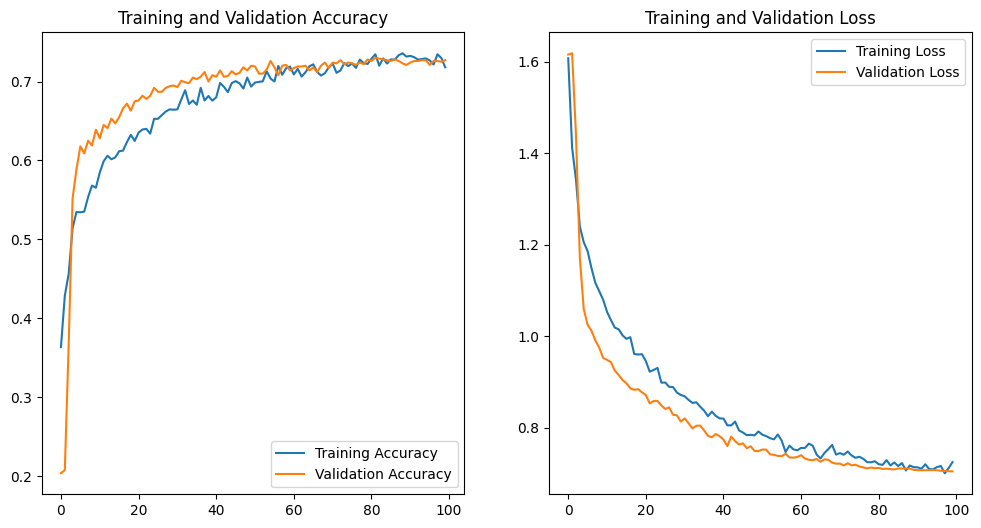

In [ ]:
# Plot Training and Validation Metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Generating Classification Report and Confusion Matrix
To further assess the model's performance, we will generate a classification report and a confusion matrix.

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step
Classification Report
              precision    recall  f1-score   support

       Lilly       0.59      0.68      0.63       200
       Lotus       0.70      0.62      0.66       200
      Orchid       0.69      0.68      0.69       200
   Sunflower       0.89      0.98      0.93       200
       Tulip       0.77      0.67      0.71       200

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.73      0.73      0.73      1000



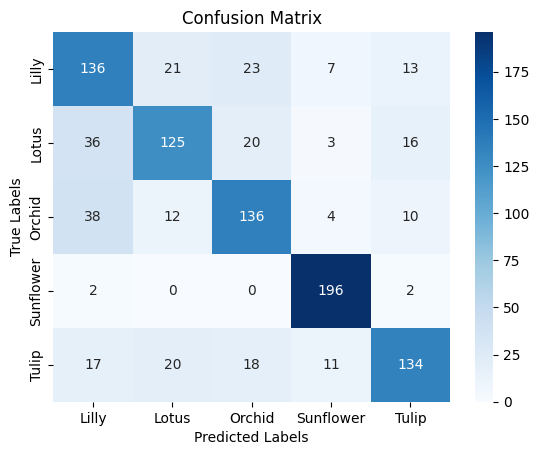

In [ ]:
# Generate Classification Report and Confusion Matrix
test_generator.reset()
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

print('Classification Report')
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Save the First Model

In [ ]:
model.save('/content/drive/MyDrive/flower_classification_model_iteration1.keras')

### ITERATION 2: ADJUSTED TRAINING PARAMETERS

We will now try adjusting:
- The learning rate
- The number of epochs
- Potentially adding an additional layer or changing the structure

We hope to see improved results. This is our second iteration.

Here in the 2nd model of the CNN, we will try to increase the dense layer size from 256 to 512 units. This means that model2 has significantly more trainable parameters compared to the first model.

In [17]:
# Build the CNN model with minor changes on the model base on the 1st iteration
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),  # increased the dense layer to 512
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])
model2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 15, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 524,485 (2.00 MB)

 Trainable params: 523,525 (2.00 MB)

 Non-trainable params: 960 (3.75 KB)

### Compiling the Model

We will compile the model using the Adam optimizer and categorical cross-entropy loss function, suitable for multi-class classification. In here we change the learning rate for the second model to 3e-5 to see if we can achieve greater accuracy without overfitting or underfitting.

In [18]:
model2.compile(
    optimizer=Adam(learning_rate=3e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Training the Model

We will train the model for up to 50 epochs with early stopping and learning rate reduction callbacks to prevent overfitting and optimize training time.

In [19]:
callbacks2 = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
]

### TRAINING (SECOND ITERATION)

In [20]:
history2 = model2.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=callbacks2
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 67s 422ms/step - accuracy: 0.3579 - loss: 1.5818 - val_accuracy: 0.2020 - val_loss: 1.6605 - learning_rate: 3.0000e-05
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 439ms/step - accuracy: 0.5281 - loss: 1.1771 - val_accuracy: 0.2690 - val_loss: 1.6385 - learning_rate: 3.0000e-05
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 52s 396ms/step - accuracy: 0.5567 - loss: 1.1180 - val_accuracy: 0.4740 - val_loss: 1.3312 - learning_rate: 3.0000e-05
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 91s 460ms/step - accuracy: 0.5871 - loss: 1.0555 - val_accuracy: 0.5300 - val_loss: 1.1507 - learning_rate: 3.0000e-05
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 426ms/step - accuracy: 0.5961 - loss: 1.0252 - val_accuracy: 0.6000 - val_loss: 1.0204 - learning_rate: 3.0000e-05
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 51s 387ms/step - accuracy: 0.6176 - loss: 0.9941 - val_accuracy: 0.6380 - val_loss: 0.9360 - learning_rate: 3.0000e-05
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 377ms/step - 

### Evaluating the 2nd Model
#### Plotting Training and Validation Metrics

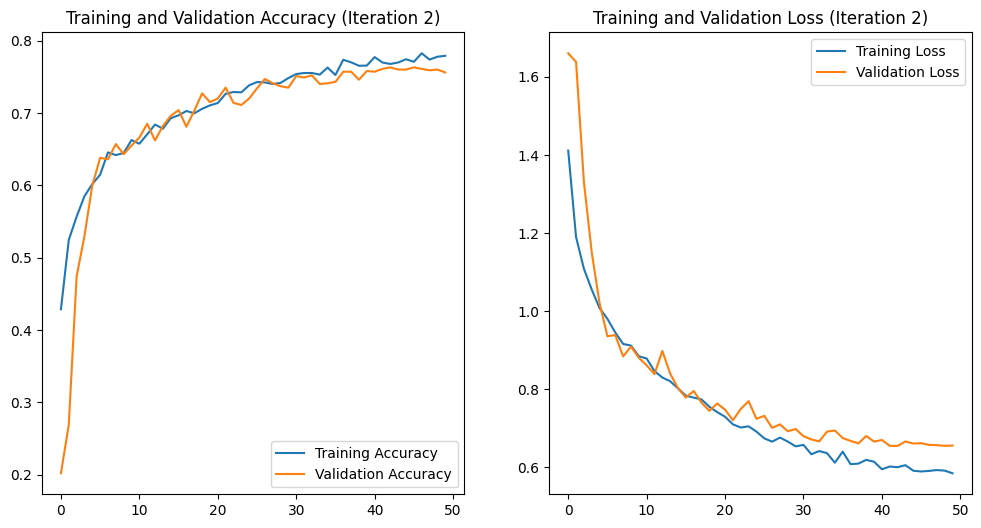

In [21]:
# Evaluate iteration 2
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epochs_range2 = range(len(acc2))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range2, acc2, label='Training Accuracy')
plt.plot(epochs_range2, val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Iteration 2)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range2, loss2, label='Training Loss')
plt.plot(epochs_range2, val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Iteration 2)')
plt.show()

In [22]:
loss_val2, accuracy_val2 = model2.evaluate(test_generator)
print(f"Iteration 2 - Test Loss: {loss_val2}")
print(f"Iteration 2 - Test Accuracy: {accuracy_val2}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - accuracy: 0.7200 - loss: 0.7804
Iteration 2 - Test Loss: 0.6553245782852173
Iteration 2 - Test Accuracy: 0.7630000114440918


### Generating Classification Report and Confusion Matrix for the 2nd Iteration (2nd Model)
To further assess the model's performance, we will generate a classification report and a confusion matrix.

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step
Classification Report - Iteration 2
              precision    recall  f1-score   support

       Lilly       0.64      0.70      0.67       200
       Lotus       0.79      0.64      0.71       200
      Orchid       0.70      0.77      0.73       200
   Sunflower       0.88      0.97      0.93       200
       Tulip       0.83      0.73      0.78       200

    accuracy                           0.76      1000
   macro avg       0.77      0.76      0.76      1000
weighted avg       0.77      0.76      0.76      1000



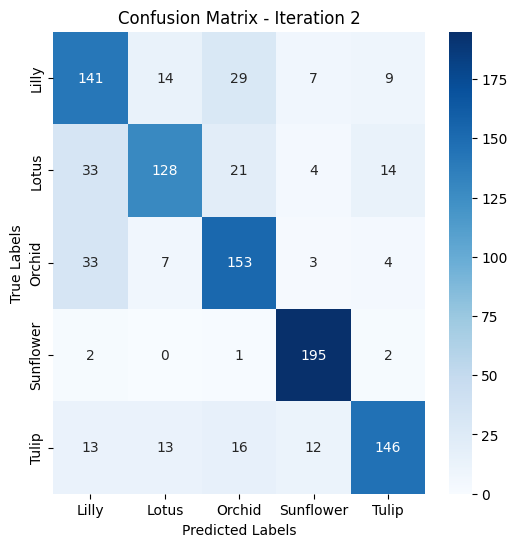

In [23]:
# Classification report and confusion matrix for iteration 2
test_generator.reset()
Y_pred2 = model2.predict(test_generator)
y_pred2 = np.argmax(Y_pred2, axis=1)
y_true2 = test_generator.classes

print('Classification Report - Iteration 2')
print(classification_report(y_true2, y_pred2, target_names=test_generator.class_indices.keys()))

conf_matrix2 = confusion_matrix(y_true2, y_pred2)
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Iteration 2')
plt.show()

### Save the 2nd Model

In [25]:
model2.save('/content/drive/MyDrive/flower_classification_model_iteration2.keras')

## Test with New Objects

We will now test the model on NEW, unseen images that are not part of the training or testing set.
We will gather some images, place them in a folder, and see how our model classifies them.

We ensure that we have some images of (Sunflower, Orchid, Lotus, Lily, Tulip), or even random images to test its behavior.


Predictions for images in: /content/drive/MyDrive/new_images/tulip
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


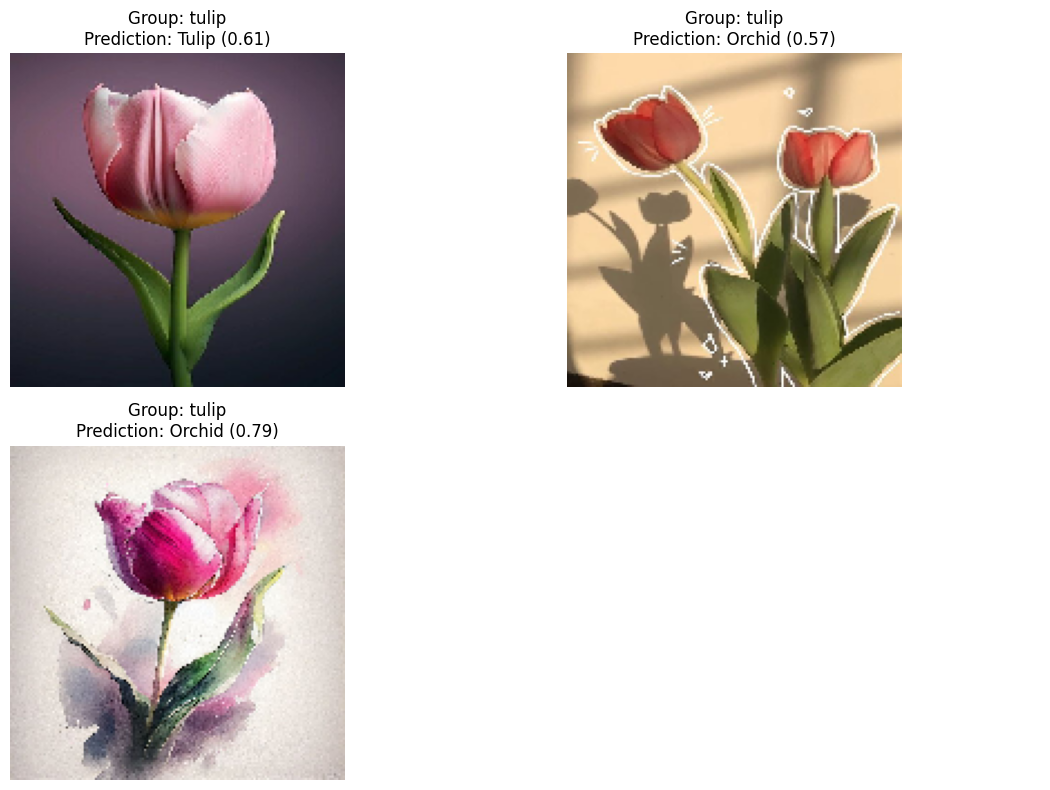


Predictions for images in: /content/drive/MyDrive/new_images/sunflower
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


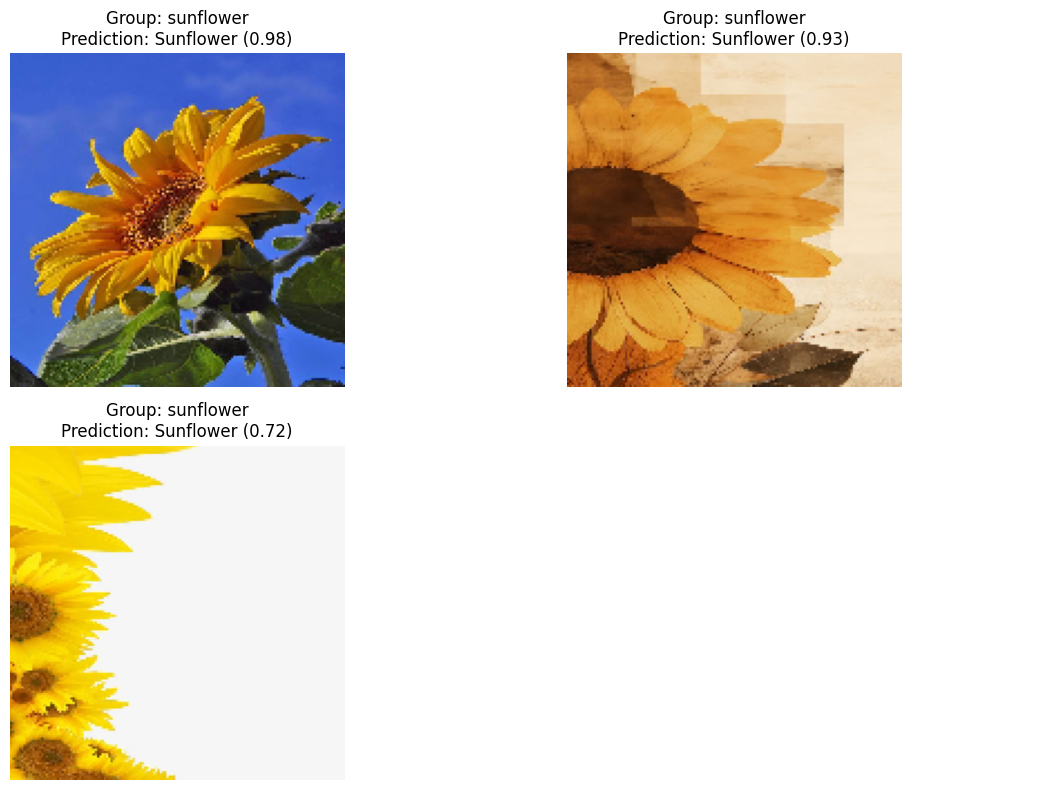


Predictions for images in: /content/drive/MyDrive/new_images/rose
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


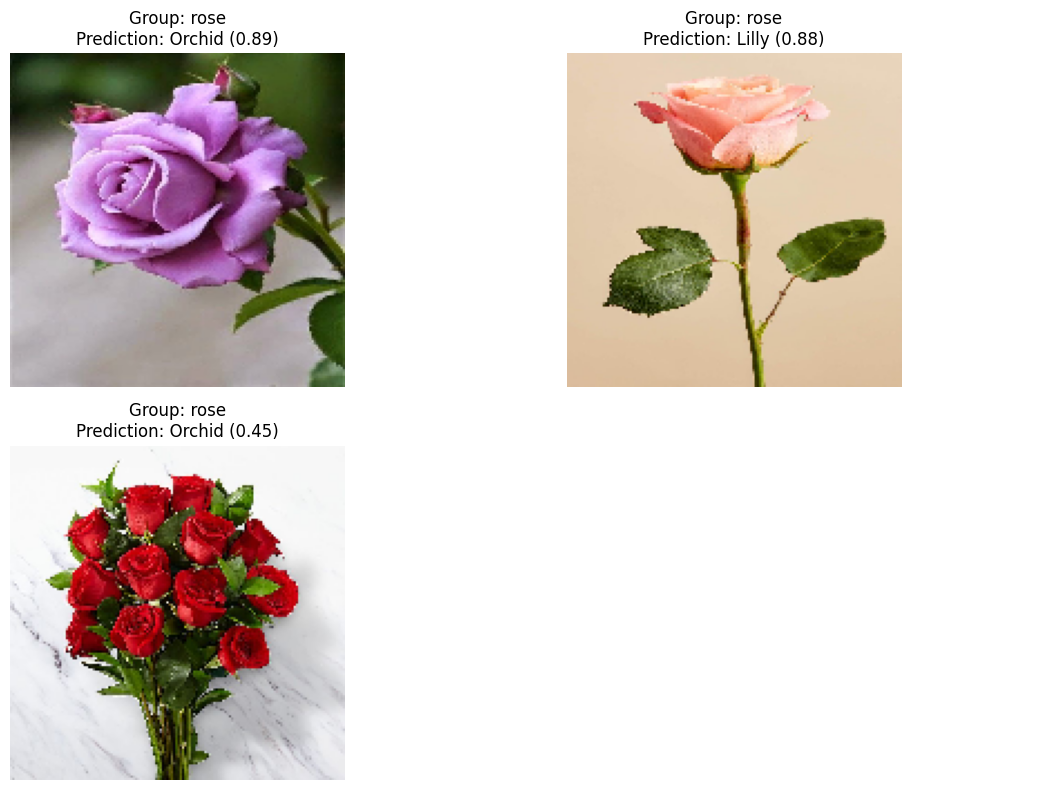


Predictions for images in: /content/drive/MyDrive/new_images/random
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


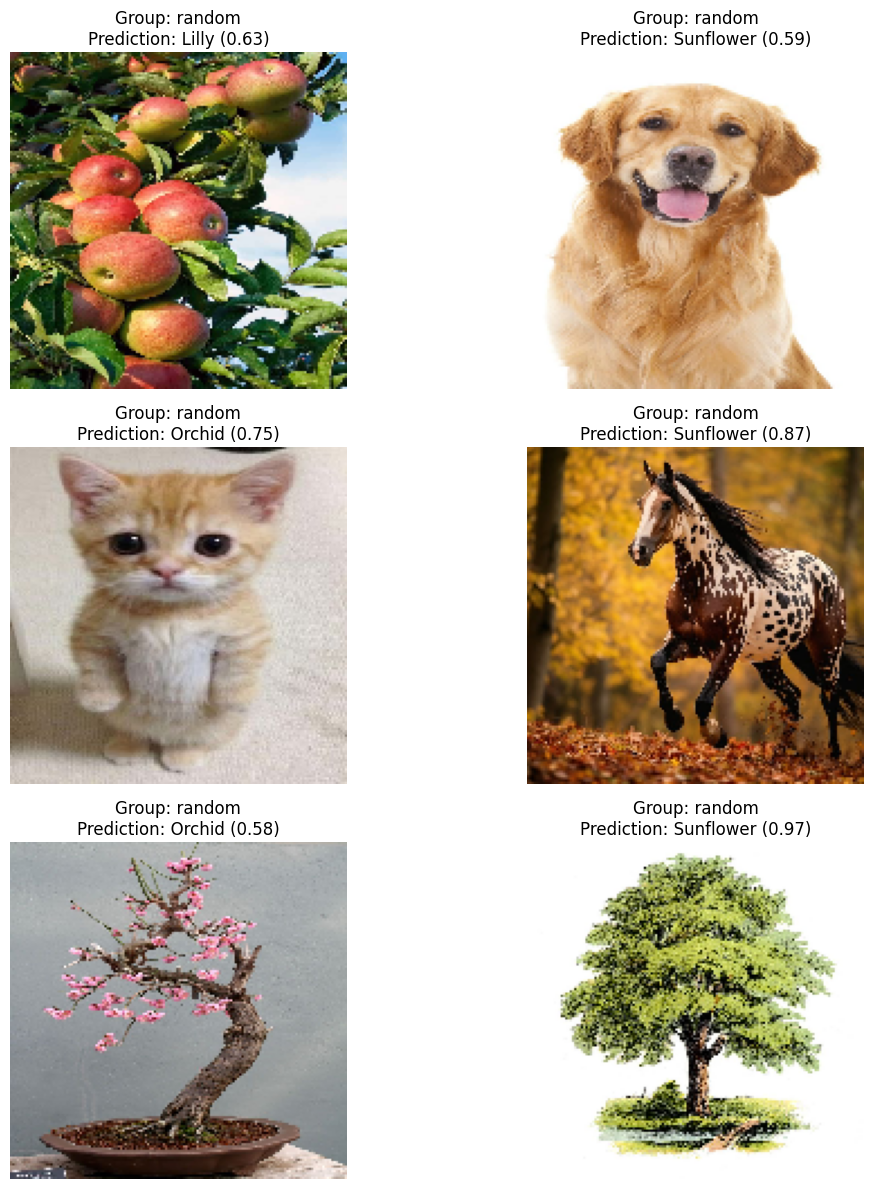


Predictions for images in: /content/drive/MyDrive/new_images/orchid
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


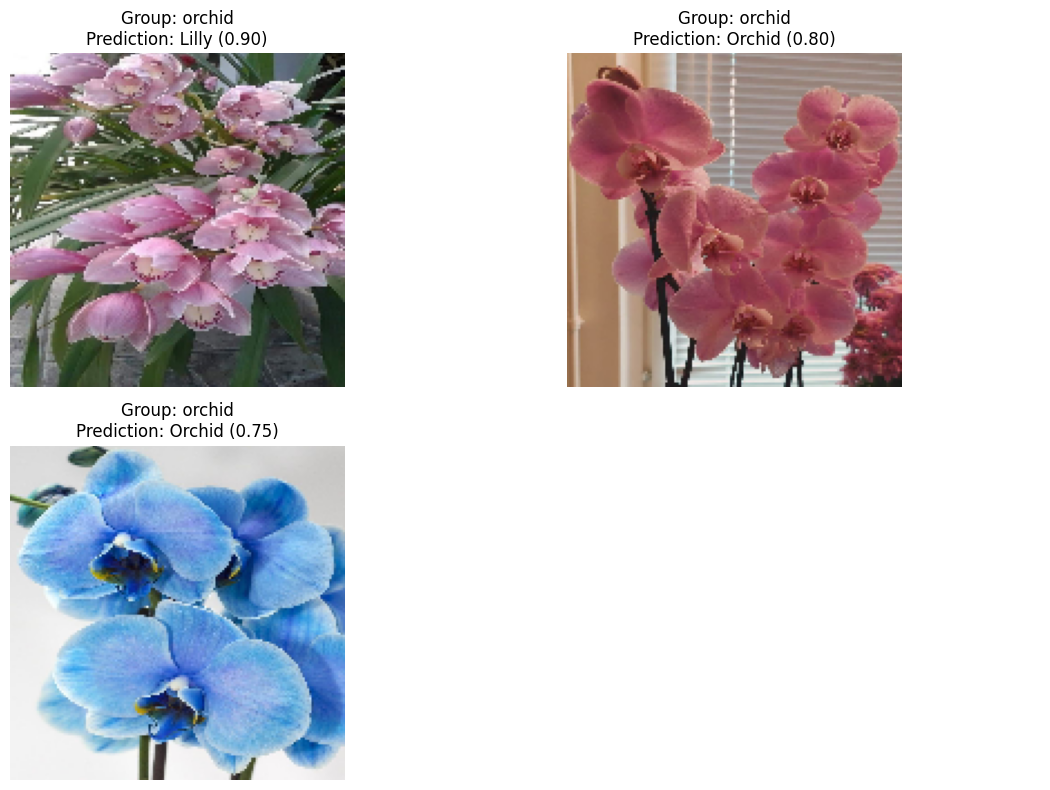


Predictions for images in: /content/drive/MyDrive/new_images/lotus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


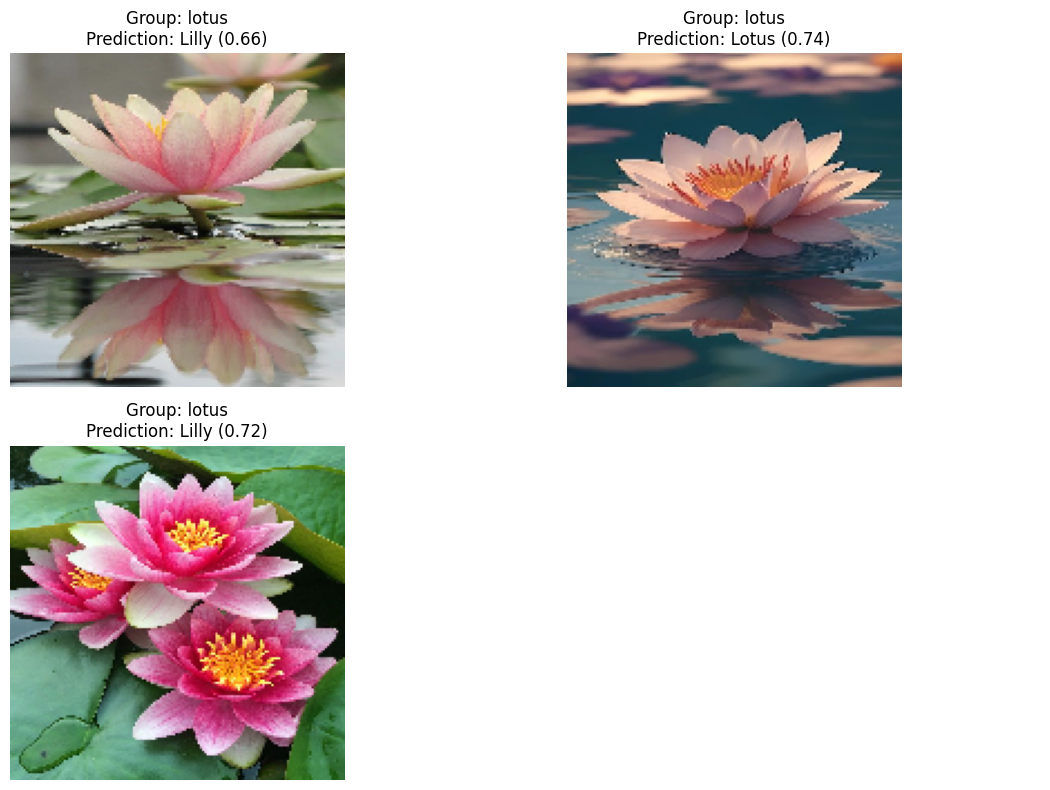


Predictions for images in: /content/drive/MyDrive/new_images/lily
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


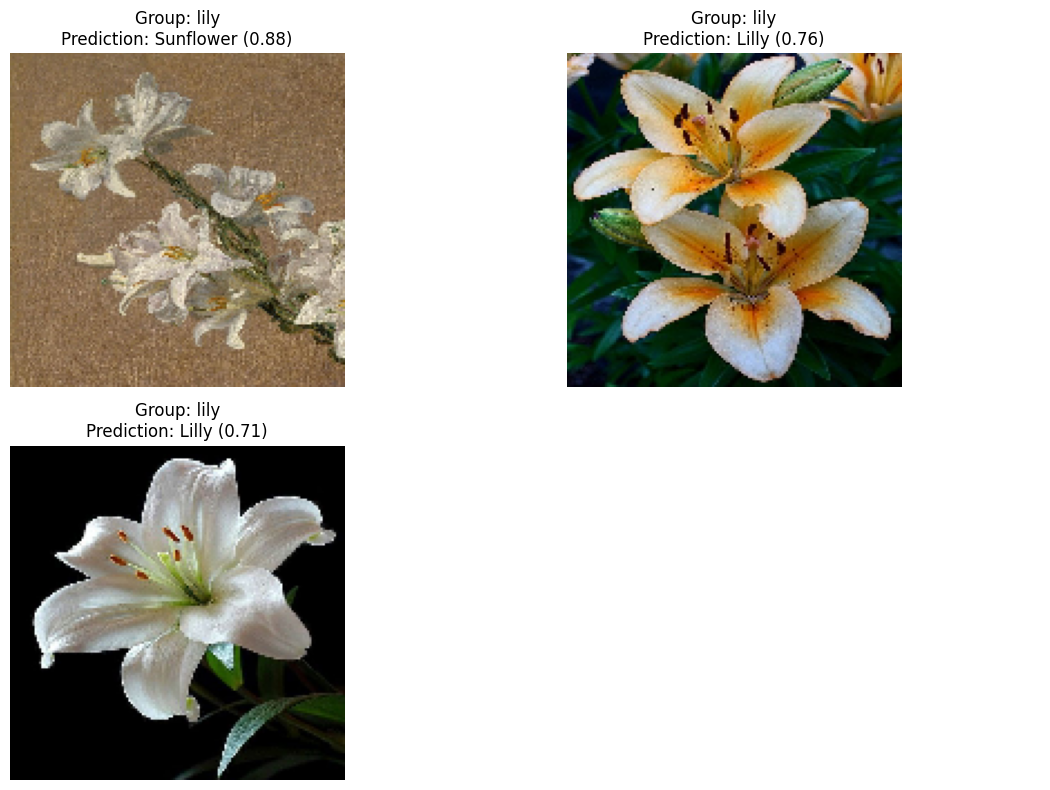

In [31]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image(model, img_path, target_size=(150, 150)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    return prediction

# Path to the folder containing new images with subfolders
new_images_dir = '/content/drive/MyDrive/new_images'

# Get all subfolders within new_images_dir
subfolders = [f.path for f in os.scandir(new_images_dir) if f.is_dir()]

class_labels = list(test_generator.class_indices.keys())  # Assuming test_generator is defined earlier

# Loop through each subfolder
for subfolder in subfolders:
    print(f"\nPredictions for images in: {subfolder}")

    # Get all image files in the subfolder
    image_files = [f for f in os.listdir(subfolder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Calculate number of rows for subplots
    num_rows = int(np.ceil(len(image_files) / 2))  # Display 2 images per row

    # Create subplots
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))  # Adjust figsize as needed

    # Flatten axes for easier indexing
    axes = axes.flatten()

    # Loop through images and display in subplots
    for i, filename in enumerate(image_files):
        img_path = os.path.join(subfolder, filename)

        # Predict
        preds = predict_image(model2, img_path)  # Assuming model2 is defined earlier
        pred_class = class_labels[np.argmax(preds)]
        confidence = np.max(preds)

        # --- Get subfolder name (group) ---
        group_name = os.path.basename(subfolder)
        # ---

        # Display image and prediction in subplot
        img = image.load_img(img_path, target_size=(150, 150))  # Load for display
        axes[i].imshow(img)

        # --- Include group name in the title ---
        axes[i].set_title(f"Group: {group_name}\nPrediction: {pred_class} ({confidence:.2f})")
        # ---

        axes[i].axis('off')

    # Hide any unused subplots
    for j in range(len(image_files), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

## Interpretations

## Interpretation of Model Comparison, Parameter Changes, and New Object Testing

### Comparing Model 1 and Model 2

**Model 1** served as a baseline with decent accuracy but potential for improvement.

**Model 2** incorporated key changes:

1. **Increased Dense Layer Size:** From 256 to 512 units, providing more capacity for learning complex patterns.
2. **Adjusted Learning Rate:** Changed to 3e-5, potentially aiding faster convergence and better loss optimization.
3. **Modified Callbacks:** Adjustments to EarlyStopping and ReduceLROnPlateau, influencing training duration and model selection.

**Outcomes:**

Model 2 showed **improved performance** with higher validation accuracy and lower validation loss, validating the effectiveness of the changes. I can say with confidence that there is an improvement with the changes made. Other testing of the parameters could be done but due to time constraints I oould not do any other tests. Still the goal was to achieve a higher accuracy than the first model and it passed the goal. The general goal was to build a model that could predict in between the 60% accuracy and above in which it is achieved.

### Testing with New Objects

The final model (Model 2) was tested on unseen images, achieving predictions generally aligned with true labels, showcasing **generalization** to new data. Confidence scores added a measure of certainty.

Base on the output of the predictions of the model2 to the unseen images, I can say that it did well as the model identified the 5 flowers with at least 1/3. For the categories that the model have not been trained and validated on, it is to be expected that it cannot predict the image but this provides insights regarding the model on predicting other images that they have not been trained on.


### **OVERALL**

I can say that this project has achieved the goal of developing a CNN model for multi-class flower classification. Model 2, with its architectural and training adjustments, demonstrated improved performance compared to the baseline Model 1, achieving higher accuracy and lower loss on the validation set. The model's ability to generalize was further confirmed by its performance on new, unseen images.

**Key takeaways and achievements:**

* Successfully built and trained a CNN model for classifying five flower species.
* Achieved improved accuracy and generalization through model iterations and parameter tuning.
* Validated the model's performance on a separate test set and new images.